In [1]:
import sys
sys.path.insert(0, '../Utilities/')
import os
import sympy

from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
from pysr import PySRRegressor

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
Nt=1000
P=np.zeros(Nt)
T=np.zeros(Nt)
k_t=2
r_t=12
dt=0.001

P[0]=0.2 #Initial conditions
T[0]=0
for i in range(1,Nt):
    P[i]=P[i-1]+ P[i-1]*r_t*(1-P[i-1]/k_t)*dt
    T[i]=T[i-1]+dt

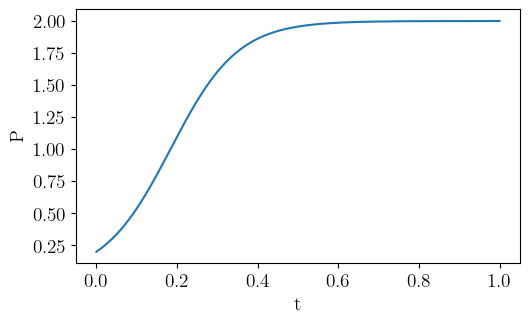

In [3]:
plt.plot(T,P)
plt.xlabel('t', fontsize=14)
plt.ylabel('P', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.tight_layout()
plt.savefig('../Figuras/312/Logistic.png')
plt.savefig('../Figuras/312/Logistic.pdf')
plt.savefig('../Figuras/312/Logistic.svg')
plt.show()

In [4]:
np.random.seed(seed=1234)
tf.random.set_seed(1234)
tf.config.experimental.enable_tensor_float_32_execution(False)
#os.environ[‘TF_ENABLE_AUTO_MIXED_PRECISION’] = ‘1’



# Initalization of Network
def hyper_initial(size):
    in_dim = size[0]
    out_dim = size[1]
    std = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal(shape=size, stddev = std))

# Neural Network 
def DNN(X, W, b):
    A = X
    L = len(W)
    for i in range(L-1):
        A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
    Y = tf.add(tf.matmul(A, W[-1]), b[-1])
    return Y

def train_vars(W, b):
    return W + b 

def net(t, w, b):
    p = DNN(t, w, b)
    return p

def loss_weight(N_r, N_b):
    lambda_b = tf.Variable(tf.reshape(tf.repeat(1000.0, N_b), (N_b, -1))) 
    lambda_r = tf.Variable(tf.ones(shape=[N_r, 1]), dtype=tf.float32)
    return lambda_r, lambda_b

#@tf.function(jit_compile=True)
@tf.function()
def net_f(t, W_p, b_p, W_phi, b_phi):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([t])
        p=net(t, W_p, b_p)
        phi=net(p, W_phi, b_phi)
    p_t = tape1.gradient(p, t) 
    f = p_t - phi
    return f


#@tf.function()
@tf.function()
def train_step(W_p, b_p, W_phi, b_phi, X_u_train_tf, u_train_tf, X_f_train_tf, u_star_tf,lambda_r, lambda_b, opt):
    t_u = X_u_train_tf
    t_f = X_f_train_tf
    U_star = u_star_tf

    with tf.GradientTape(persistent=True) as tape:
        tape.watch([W_p, b_p, W_phi, b_phi, lambda_r, lambda_b])
        u_nn = net(t_u, W_p, b_p) 
        phi_nn = net(U_star, W_phi, b_phi) 
        f_nn = net_f(t_f, W_p, b_p, W_phi, b_phi)
        loss_u = tf.reduce_mean(tf.square(lambda_b*(u_nn - u_train_tf)))
        loss_f = tf.reduce_mean(tf.square(lambda_r*f_nn)) 
        loss_phi = tf.reduce_mean(tf.square(phi_nn - r_t*U_star*(1-U_star/k_t)))

        loss =  loss_u + loss_f

    grads_p = tape.gradient(loss, train_vars(W_p, b_p))
    grads_phi = tape.gradient(loss, train_vars(W_phi, b_phi))
    grads_u = tape.gradient(loss, lambda_r)
    grads_b = tape.gradient(loss, lambda_b)

    opt.apply_gradients(zip(grads_p, train_vars(W_p, b_p)))
    opt.apply_gradients(zip(grads_phi, train_vars(W_phi, b_phi)))
    opt.apply_gradients(zip([-grads_u], [lambda_r]))
    opt.apply_gradients(zip([-grads_b], [lambda_b]))
   
    return loss, loss_u, loss_f, loss_phi




# N_u = 100 # Number of Initial and Boundary data points
N_f = 100 # Number of residual point
N_d = 200 #Number of data

layers = [1, 50, 50, 1]

L = len(layers)
W_p = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b_p = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]
W_phi = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b_phi = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]

lambda_r, lambda_b = loss_weight(N_f, N_d)


2024-10-28 19:50:49.127987: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2024-10-28 19:50:49.128537: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cublas64_11.dll'; dlerror: cublas64_11.dll not found
2024-10-28 19:50:49.129046: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cublasLt64_11.dll'; dlerror: cublasLt64_11.dll not found
2024-10-28 19:50:49.129553: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cufft64_10.dll'; dlerror: cufft64_10.dll not found
2024-10-28 19:50:49.130044: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'curand64_10.dll'; dlerror: curand64_10.dll not found
2024-10-28 19:50:49.130539: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dyna

In [5]:
u_star = P.reshape([-1, 1])
X_star = T.reshape([-1, 1])

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)  

# Initial Condition
xx1 = T[0]
uu1 = P[0]

# Additional data
idx = np.random.choice(P.shape[0], N_d-1, replace=False)
xxd = T[idx]
uud = P[idx]

X_u_train = np.concatenate(([xx1],xxd)).reshape([-1,1])
u_train = np.concatenate(([uu1],uud)).reshape([-1,1])

X_f_train = lb + (ub-lb)*lhs(1, N_f)
# X_f_train = np.vstack((X_f_train, X_u_train))


X_u_train_tf = tf.convert_to_tensor(X_u_train, dtype=tf.float32)
u_train_tf =   tf.convert_to_tensor(u_train, dtype=tf.float32)
X_f_train_tf = tf.convert_to_tensor(X_f_train, dtype=tf.float32)
u_star_tf = tf.convert_to_tensor(u_star, dtype=tf.float32)

In [6]:
lr = 1e-3
Nmax = 10**5
optimizer = tf.optimizers.Adam(learning_rate=lr)

start_time = time.time()
n=0
loss = []
loss_phi=[]
loss_u=[]
loss_f=[]


while n <= Nmax:

    loss_, loss_u_, loss_f_, loss_phi_ = train_step(W_p, b_p, W_phi, b_phi, X_u_train_tf, u_train_tf, X_f_train_tf,u_star_tf,lambda_r, lambda_b, optimizer)
    loss.append(loss_)
    loss_phi.append(loss_phi_)
    loss_u.append(loss_u_)
    loss_f.append(loss_f_)


    if n % 10 == 0:
        print(f"Iteration is: {n}")
        print(f"Total loss is: {loss_}")

        print(f"Data loss is: {loss_u_}")
        print(f"Physicial loss is: {loss_f_}")
        print(f"Function unknown loss is: {loss_phi_}")

    n+=1

elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))

Iteration is: 0
Total loss is: 2779403.0
Data loss is: 2779403.0
Physicial loss is: 0.003904314711689949
Function unknown loss is: 7.20570182800293
Iteration is: 10
Total loss is: 1303809.25
Data loss is: 1303809.25
Physicial loss is: 0.05823780596256256
Function unknown loss is: 6.132396697998047
Iteration is: 20
Total loss is: 153656.46875
Data loss is: 153656.203125
Physicial loss is: 0.26612311601638794
Function unknown loss is: 5.970122814178467
Iteration is: 30
Total loss is: 226393.203125
Data loss is: 226392.921875
Physicial loss is: 0.28344425559043884
Function unknown loss is: 5.88208532333374
Iteration is: 40
Total loss is: 104471.625
Data loss is: 104471.578125
Physicial loss is: 0.0437413789331913
Function unknown loss is: 4.863034248352051
Iteration is: 50
Total loss is: 109020.9375
Data loss is: 109020.9296875
Physicial loss is: 0.00843534804880619
Function unknown loss is: 3.8514468669891357
Iteration is: 60
Total loss is: 93289.3515625
Data loss is: 93289.34375
Physici

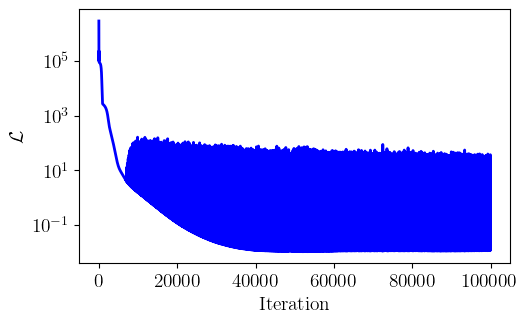

In [7]:
Nmax=len(loss)
it = np.arange(0,Nmax, 1)
loss_list = [loss[i].numpy() for i in range(0,Nmax)]
loss_phi_list = [loss_phi[i].numpy() for i in range(0,Nmax)]
loss_u_list = [loss_u[i].numpy() for i in range(0,Nmax)]
loss_f_list = [loss_f[i].numpy() for i in range(0,Nmax)]



plt.semilogy(it, np.asarray(loss_list), 'b-', linewidth = 2, label = 'Total')  
# plt.semilogy(it, np.asarray(loss_phi_list), 'r-', linewidth = 2, label = '$\mathcal{L}_\phi$')     
# plt.semilogy(it, np.asarray(loss_u_list), 'y-', linewidth = 2, label = '$\mathcal{L}_u$')    
# plt.semilogy(it, np.asarray(loss_f_list), 'g-', linewidth = 2, label = '$\mathcal{L}_f$')       



plt.xlabel('Iteration', fontsize=14)
plt.ylabel('$\mathcal{L}$', fontsize=14)    
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.tight_layout()
plt.savefig('../Figuras/312/Loss.png')
plt.savefig('../Figuras/312/Loss.pdf')
plt.savefig('../Figuras/312/Loss.svg')
plt.show()

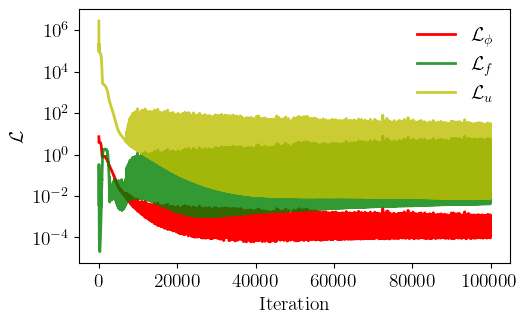

In [8]:
# plt.semilogy(it, np.asarray(loss_list), 'b-', linewidth = 2, label = 'Total')  
plt.semilogy(it, np.asarray(loss_phi_list), 'r-', linewidth = 2, label = '$\mathcal{L}_\phi$') 
plt.semilogy(it, np.asarray(loss_f_list), 'g-', linewidth = 2, alpha=0.8,    label = '$\mathcal{L}_f$') 
plt.semilogy(it, np.asarray(loss_u_list), 'y-', linewidth = 2, alpha=0.8,   label = '$\mathcal{L}_u$')    




plt.legend(fontsize=14, frameon=False,)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('$\mathcal{L}$', fontsize=14)    
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.tight_layout()
plt.savefig('../Figuras/312/Loss_split.png')
plt.savefig('../Figuras/312/Loss_split.pdf')
plt.savefig('../Figuras/312/Loss_split.svg')
plt.show()

In [9]:
def predict(X_star_tf, w, b):
    x_star = X_star_tf
    u_pred = net(x_star, w, b)
    return u_pred

## Evaluating total function
X_star_tf = tf.convert_to_tensor(X_star, dtype=tf.float32)    
u_pred = predict(X_star_tf, W_p, b_p)
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' %(error_u))                     
Error = 100* np.linalg.norm(u_star - u_pred) / np.linalg.norm(u_pred)

## Evaluating unknown function
U_star_tf = tf.convert_to_tensor(u_star, dtype=tf.float32) 
phi_pred = predict(U_star_tf, W_phi, b_phi)
phi_star=r_t*u_star*(1-u_star/k_t)
error_phi = np.linalg.norm(phi_star-phi_pred,2)/np.linalg.norm(phi_star,2)
print('Error phi: %e' %(error_phi)) 
Error_phi = 100* np.linalg.norm(phi_star - phi_pred) / np.linalg.norm(phi_pred)


Error u: 6.187957e-05
Error phi: 3.980664e-03


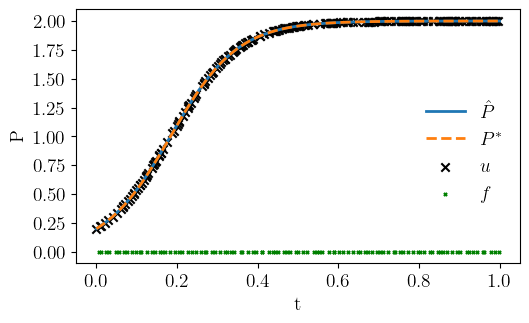

In [10]:
plt.plot(T, u_pred, linewidth=2, label='$\hat{P}$')
plt.plot(T, P, linestyle='--',linewidth=2, label='$P^*$')
plt.scatter(X_u_train, u_train, marker='x', color='black',label='$u$')
plt.scatter(X_f_train_tf, np.zeros_like(X_f_train), marker='x', s=5, color='green',label='$f$')
# plt.scatter(X_f_train, np.zeros(len(X_f_train)), marker='x')
plt.legend(fontsize=14, ncols=1, frameon=False,  bbox_to_anchor=(1, 0.7))
plt.xlabel('t', fontsize=14)
plt.ylabel('P', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.tight_layout()
plt.savefig('../Figuras/312/Result.png')
plt.savefig('../Figuras/312/Result.pdf')
plt.savefig('../Figuras/312/Result.svg')
plt.show()

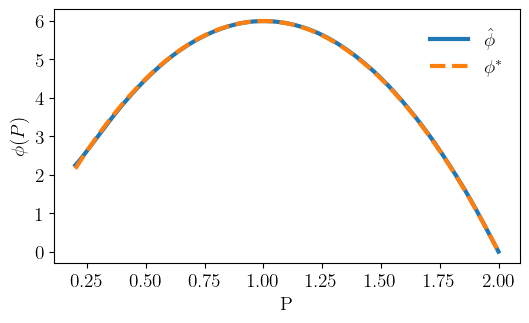

In [11]:
plt.plot(P, phi_pred,linewidth=3, label='$\hat{\phi}$')
plt.plot(P, phi_star, linewidth=3,linestyle='--', label='$\phi^*$')
# plt.scatter(X_f_train_tf, np.zeros_like(X_f_train), marker='x', s=5, color='green',label='$f$')

# plt.legend(fontsize=14, ncols=1, frameon=False,  bbox_to_anchor=(1, 0.7))
plt.legend(fontsize=14, ncols=1, frameon=False)

plt.xlabel('P', fontsize=14)
plt.ylabel('$\phi(P)$', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.tight_layout()
plt.savefig('../Figuras/312/Result_phi.png')
plt.savefig('../Figuras/312/Result_phi.pdf')
plt.savefig('../Figuras/312/Result_phi.svg')
plt.show()

In [12]:
Nt=1000
T_int=np.zeros(Nt)
P_int=np.zeros(Nt)

dt=0.001

T_int[0]=0
P_int[0]=np.array(u_pred[0,0:1]) #Initial conditions


for i in range(1,Nt):

    P_int[i]=P_int[i-1]+predict(tf.convert_to_tensor(P_int[i-1].reshape([-1,1]), dtype=tf.float32), W_phi, b_phi)*dt
    T_int[i]=T_int[i-1]+dt

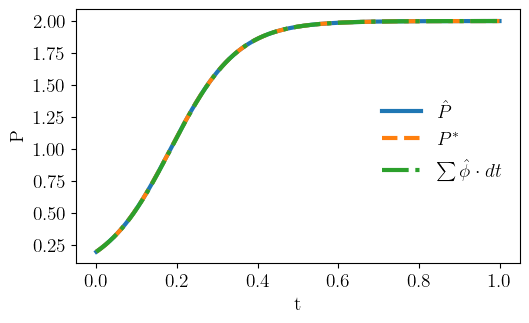

In [13]:
plt.plot(T, u_pred, linewidth=3, label='$\hat{P}$')
plt.plot(T, P, linestyle='--',linewidth=3, label='$P^*$')
plt.plot(T_int, P_int, linestyle='-.',linewidth=3, label='$\sum \hat{\phi} \cdot dt$')

plt.legend(fontsize=14, ncols=1, frameon=False,  bbox_to_anchor=(1, 0.7))
plt.xlabel('t', fontsize=14)
plt.ylabel('P', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14) 


plt.tight_layout()
plt.savefig('../Figuras/312/Result_int.png')
plt.savefig('../Figuras/312/Result_int.pdf')
plt.savefig('../Figuras/312/Result_int.svg')
plt.show()

## Symbolic Regression

In [14]:
# Create and train the PySR model
model = PySRRegressor(
    niterations=40,
    binary_operators=["+", "*"],
    # unary_operators=["cos", "exp", "sin", "inv(x) = 1/x"],
    unary_operators=["exp", "inv(x) = 1/x"],
    extra_sympy_mappings={"inv": lambda x: 1 / x},
    elementwise_loss="loss(prediction, target) = (prediction - target)^2"
)


In [15]:
# Fit phi
model.fit(u_star, np.array(phi_pred))
print(model)

c:\Users\julia\anaconda3\envs\pinns\lib\site-packages\pysr\sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Compiling Julia backend...


[ Info: Started!



Expressions evaluated per second: 1.710e+05
Head worker occupation: 39.1%
Progress: 355 / 600 total iterations (59.167%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           6.752e+00  1.594e+01  y = x₀
2           4.536e+00  3.977e-01  y = inv(0.55504)
4           3.792e+00  8.964e-02  y = inv(x₀) + 0.92338
5           2.065e+00  6.078e-01  y = -3.0793 * (-2.0552 + x₀)
7           1.170e-04  4.888e+00  y = (-5.9996 * x₀) * (x₀ + -2.0003)
9           1.094e-04  3.336e-02  y = -0.015479 + ((12.029 + (x₀ * -6.0099)) * x₀)
13          8.570e-05  6.108e-02  y = (-2 + x₀) * ((-5.9709 + ((0.024388 * -1.2279) * x₀)) * x₀)
17          8.570e-05  2.563e-06  y = ((x₀ + (x₀ * (-6.9113 + ((x₀ + (x₀ + x₀)) * -0.0099522))))...
                                   + 11.942) * x₀
18          7.930e-05  7.755e-02  y = ((((x₀ * -6.0744) + -0.15361) + 0.23885) * (-1.9982 + x₀))...
           

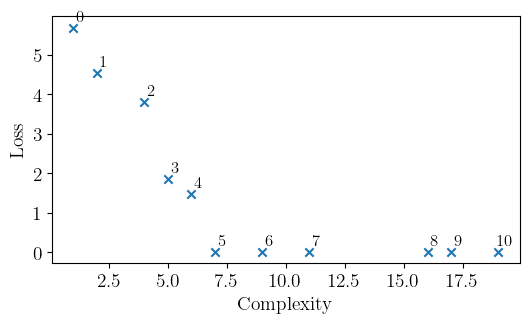

In [16]:
# Extraer las métricas de las ecuaciones
equations_df = model.equations_
# Obtener la complejidad y la puntuación (score) de cada ecuación
complejidades = equations_df['complexity']
errores = equations_df['loss']  # Por ejemplo, error MSE o cualquier métrica utilizada

# Crear el gráfico de dispersión
plt.scatter(complejidades, errores, marker='x')

# Añadir etiquetas de índice en cada punto
for i, (x, y) in enumerate(zip(complejidades, errores)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center', fontsize=12)

# Añadir etiquetas y título
plt.xlabel('Complexity', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14) 
plt.tight_layout()
plt.savefig('../Figuras/312/Loss_Complexity.png')
plt.savefig('../Figuras/312/Loss_Complexity.pdf')
plt.savefig('../Figuras/312/Loss_Complexity.svg')
# Mostrar gráfico
plt.show()

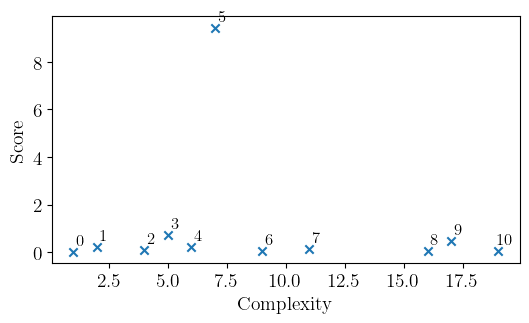

In [17]:
# Extraer complejidad y score
complejidades = equations_df['complexity']
scores = equations_df['score']

# Graficar score vs complejidad
plt.scatter(complejidades, scores, marker='x')

# Añadir etiquetas de índice en cada punto
for i, (x, y) in enumerate(zip(complejidades, scores)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center', fontsize=12)

# Añadir etiquetas y título
plt.xlabel('Complexity', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14) 
plt.tight_layout()
plt.savefig('../Figuras/312/Score_Complexity.png')
plt.savefig('../Figuras/312/Score_Complexity.pdf')
plt.savefig('../Figuras/312/Score_Complexity.svg')
# Mostrar gráfico
plt.show()


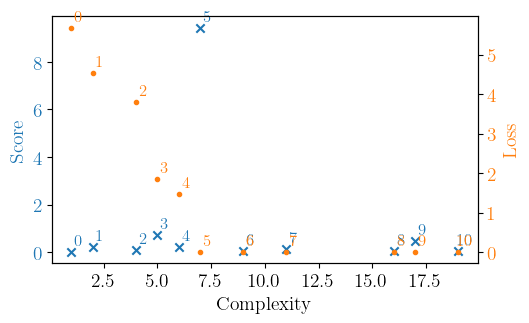

In [18]:
import matplotlib.pyplot as plt

# Obtener los colores de la paleta tab10
colors = plt.get_cmap('tab10').colors

# Crear la figura y el primer eje (izquierdo)
fig, ax1 = plt.subplots()

# Graficar score vs complejidad en el eje izquierdo usando el color tab10[0]
ax1.scatter(complejidades, scores, color=colors[0], marker='x', label='Score')
ax1.set_xlabel('Complexity', fontsize=14)
ax1.set_ylabel('Score', fontsize=14, color=colors[0])
ax1.tick_params(axis='y', labelcolor=colors[0])

# Añadir etiquetas de índice en cada punto para score
for i, (x, y) in enumerate(zip(complejidades, scores)):
    ax1.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center', fontsize=12, color=colors[0])

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

# Crear un segundo eje (derecho) que comparte el eje x
ax2 = ax1.twinx()

# Graficar errores vs complejidad en el eje derecho usando el color tab10[1]
ax2.scatter(complejidades, errores, color=colors[1], s=9, marker='o', label='Loss')
ax2.set_ylabel('Loss', fontsize=14, color=colors[1])
ax2.tick_params(axis='y', labelcolor=colors[1])

# Añadir etiquetas de índice en cada punto para errores
for i, (x, y) in enumerate(zip(complejidades, errores)):
    ax2.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center', fontsize=12, color=colors[1])

# Ajustar el gráfico para que no se corten los elementos
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.savefig('../Figuras/312/Score_Loss_Complexity.png')
plt.savefig('../Figuras/312/Score_Loss_Complexity.pdf')
plt.savefig('../Figuras/312/Score_Loss_Complexity.svg')
plt.show()


In [24]:
choose=5
exp=model.sympy(choose)
sympy.expand(exp)
sympy.factor(exp)


-12.0007463054617*x0*(0.499937432830281*x0 - 1.0)

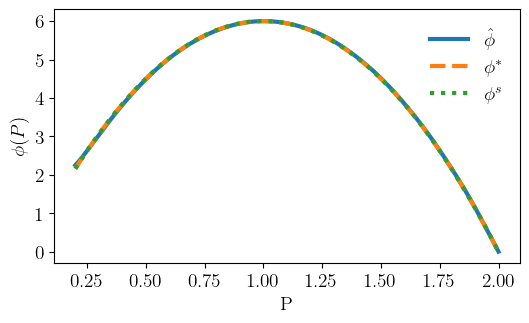

In [25]:
symb1=model.predict(u_star,choose)

plt.plot(P, phi_pred,linewidth=3, label='$\hat{\phi}$')
plt.plot(P, phi_star, linewidth=3,linestyle='--', label='$\phi^*$')
plt.plot(u_star, symb1,linewidth=3, linestyle=':', label='$\phi^s$')

plt.legend(fontsize=14, ncols=1, frameon=False)

plt.xlabel('P', fontsize=14)
plt.ylabel('$\phi(P)$', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.tight_layout()
plt.savefig('../Figuras/312/Result_phi_s.png')
plt.savefig('../Figuras/312/Result_phi_s.pdf')
plt.savefig('../Figuras/312/Result_phi_s.svg')
plt.show()


In [26]:
Nt=1000
P_symb=np.zeros(Nt)
T_symb=np.zeros(Nt)

dt=0.001

P_symb[0]=np.array(u_pred[0,0:1]) 
T_symb[0]=0
for i in range(1,Nt):
    P_symb[i]=P_symb[i-1]+model.predict(P_symb[i-1].reshape([-1,1]),choose)*dt
    T_symb[i]=T_symb[i-1]+dt

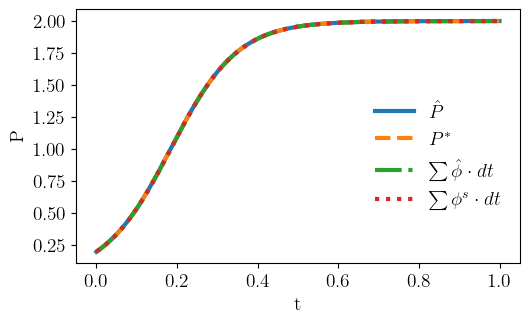

In [27]:
plt.plot(T, u_pred, linewidth=3, label='$\hat{P}$')
plt.plot(T, P, linestyle='--',linewidth=3, label='$P^*$')
plt.plot(T_int, P_int, linestyle='-.',linewidth=3, label='$\sum \hat{\phi} \cdot dt$')
plt.plot(T_symb, P_symb, linestyle=':',linewidth=3, label='$\sum \phi^s \cdot dt$')


plt.legend(fontsize=14, ncols=1, frameon=False,  bbox_to_anchor=(1, 0.7))
plt.xlabel('t', fontsize=14)
plt.ylabel('P', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14) 


plt.tight_layout()
plt.savefig('../Figuras/312/Result_int_s.png')
plt.savefig('../Figuras/312/Result_int_s.pdf')
plt.savefig('../Figuras/312/Result_int_s.svg')
plt.show()

In [28]:
## Evaluating P(t)
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error hat{P}: %e' %(error_u))                     

error_u = np.linalg.norm(P-P_int,2)/np.linalg.norm(P,2)
print('Error sum hat{phi} %e' %(error_u))         

error_u = np.linalg.norm(P-P_symb,2)/np.linalg.norm(P,2)
print('Error sum hat{phi_s} %e' %(error_u))       

Error hat{P}: 6.187957e-05
Error sum hat{phi} 6.182334e-04
Error sum hat{phi_s} 4.704655e-04
